# Detecting Brain Tumor

### Importing Libraries

In [53]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2
from PIL import Image
import matplotlib.pyplot as plt
import random
import pandas as pd

### Defining Custom Dataset Class

In [62]:
class BrainDataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None):
        self.img_labels = pd.read_csv(annotations_file)[['image', 'class']]
        self.root_dir = img_dir
        self.transform = transform
        self.cancer_folder = 'Brain Tumor/'
        self.healthy_folder = 'Healthy/'
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index):
        label = self.img_labels.iloc[index, 1]
        if label == 'tumor':
            img_path = os.path.join(self.root_dir, self.cancer_folder, self.img_labels.iloc[index, 0])
            label = 1
        else:
            img_path = os.path.join(self.root_dir, self.healthy_folder, self.img_labels.iloc[index, 0])
            label = 0
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

### Metadata

In [55]:
dataset_path = '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/'
meta_file = '/kaggle/input/brian-tumor-dataset/metadata_rgb_only.csv'
batch_size = 32
num_epochs = 5
learning_rate = 0.001

In [56]:
img_labels = pd.read_csv(meta_file)[['image', 'class']]
img_labels.iloc[4, 0]

'Cancer (100).jpg'

### Loading the data

In [63]:
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = BrainDataset(dataset_path, meta_file, transform=transform)
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the split
print(f'Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}')

Train size: 2676, Val size: 892, Test size: 893


### Defining Model Class

In [58]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [59]:
# Create the model, loss function, and optimizer
num_classes = 2
model = CNN(num_classes).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [64]:
for images, labels in train_loader:
    print(type(images), labels)
    break

<class 'torch.Tensor'> tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 1])


In [67]:
# Lists to store the training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to('cuda')
        labels = labels.to('cuda')
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
    
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("Training completed!")

Epoch [1/5], Train Loss: 0.1972, Val Loss: 0.1711
Epoch [2/5], Train Loss: 0.0559, Val Loss: 0.1472
Epoch [3/5], Train Loss: 0.0165, Val Loss: 0.1632
Epoch [4/5], Train Loss: 0.0017, Val Loss: 0.1439
Epoch [5/5], Train Loss: 0.0004, Val Loss: 0.1427
Training completed!


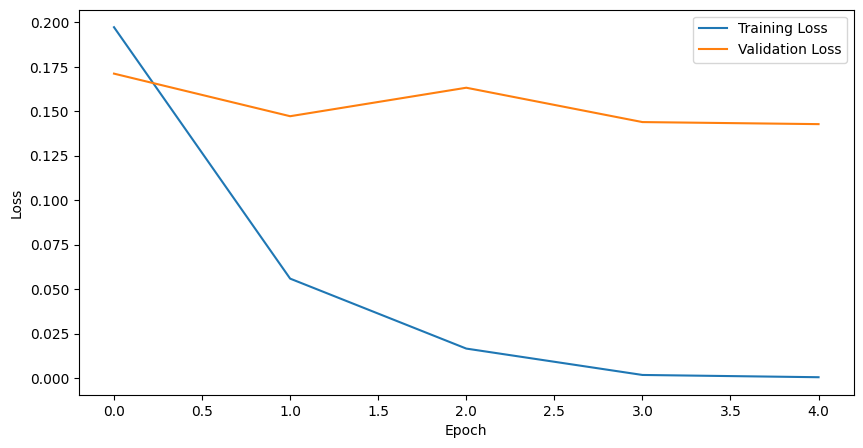

In [68]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [79]:
list(range(len(test_dataset)))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


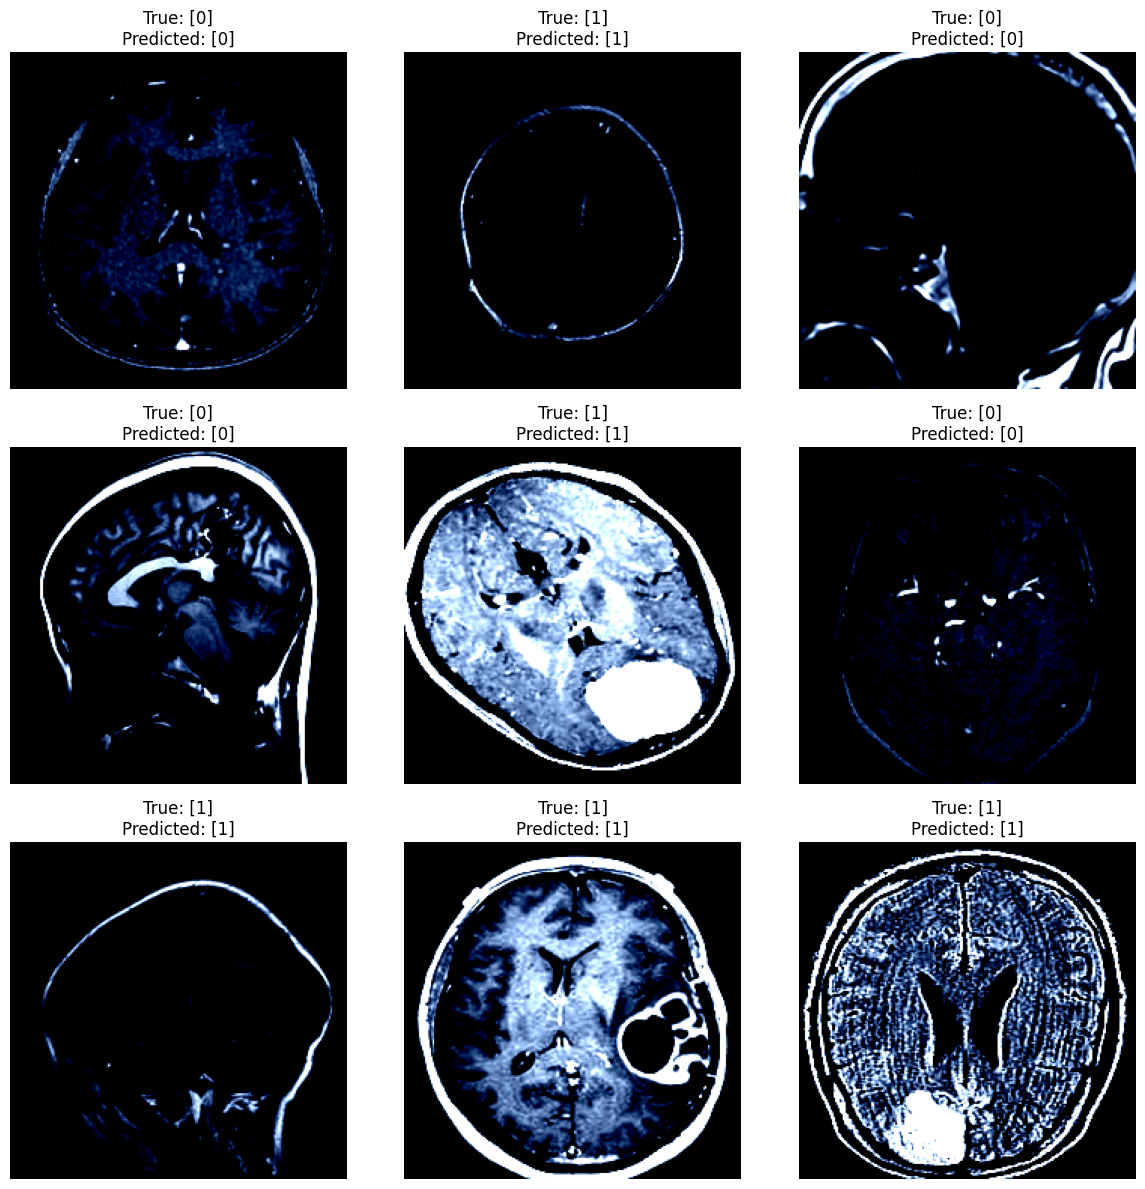

In [ ]:
# Perform sample inferences on random test images with different labels
model.eval()
with torch.no_grad():
    indices = list(range(len(test_dataset)))
    random.shuffle(indices)
    
    selected_images = []
    selected_labels = []
    selected_predicted = []
    
    for index in indices:
        image, label = test_dataset[index]
        image = image.unsqueeze(0).to('cuda')
        
        output = model(image)
        _, predicted = torch.max(output, 1)
        
        selected_images.append(image)
        selected_labels.append(label)
        selected_predicted.append(predicted.item())
        
        if len(selected_labels) == 9:
            break
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(9):
        axes[i].imshow(selected_images[i].squeeze().cpu().permute(1, 2, 0))
        axes[i].set_title(f"True: {[selected_labels[i]]}\nPredicted: {[selected_predicted[i]]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

### Export the model

In [ ]:
torch.save(model.state_dict(), '/model/brain_model.pt')